In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

# Generate Sine Wave 

In [ ]:
np.random.seed(2)

T = 20
L = 1000
N = 100

In [ ]:
x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
x.shape

In [ ]:
data = np.sin(x / 1.0 / T).astype('float64')
torch.save(data, open('traindata.pt', 'wb'))
data.shape

In [ ]:
plt.plot(data[5,: ])

In [ ]:
train_input.size(1)

To use the data in the model, `.chunk(train_input.size(1), dim=1)` splits it into slices `1, 2, ..., t, ..., L`.

In [ ]:
list(train_input.chunk(train_input.size(1), dim=1))[0].size()

# Train 

In [ ]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


In [ ]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)

## Train and Test sets 

In [ ]:
# load data and make training set
data = torch.load('traindata.pt')

# Train dataset
train_input = torch.from_numpy(data[3:, :-1])
train_target = torch.from_numpy(data[3:, 1:])

# Test dataset
test_input = torch.from_numpy(data[:3, :-1])
test_target = torch.from_numpy(data[:3, 1:])


In [ ]:
data.shape

In [ ]:
plt.plot(train_input[96].numpy())

In [ ]:
print('Train input:', train_input.size(), ', Train target:', train_target.size())

## Build the model

In [ ]:
# build the model
seq = Sequence()
seq.double()

In [ ]:
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

# optimizer = optim.Adam(seq.parameters(), lr=0.1, weight_decay=1e-3)

## Train

In [ ]:
#begin to train
for i in tqdm_notebook(range(20), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(train_input)
        loss = criterion(out, train_target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 1000
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)',
              fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(train_input.size(1)),
                 yi[:train_input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(train_input.size(1), train_input.size(1) + future), 
                 yi[train_input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.show()

# Trends and prices

* Simulate price paths according to Dai, M., Zhang, Q., & Zhu, Q. J. (2010). _Trend following trading under a regime switching model_. SIAM Journal on Financial Mathematics, 1(1), 780-810.

In [3]:
import pandas as pd
from pandas import DataFrame, Series
pd.set_option('display.max_rows', 6)

In [4]:
def sim_path(N=1000, P=np.array([[0.95, 0.05], [0.1, 0.9]]),
             mu=[-0.05, 0.1], sigma=0.35, S0=1, dt=1/250):
    
    # State simulation
    state = np.random.randint(0, 2)
    states = [state]
    for t in range(N - 1):
        state = int(np.random.multinomial(1, P[state, :]).argmax())
        states.append(state)
    
    # Price simulation
    drift = (np.array([mu[s] for s in states[1:]]) - 0.5 * sigma**2) * dt
    wiener = np.random.randn(N - 1) * sigma * np.sqrt(dt)

    S = S0 * np.concatenate((np.ones(1), np.exp(np.cumsum(drift + wiener))))
    
    res_df = DataFrame(data=dict(Close=S, State=states))
    res_df = res_df.assign(Ch = res_df.Close.pct_change().add(1).apply('log'))
    res_df = res_df.assign(Ch2 = res_df.Ch.pow(2),
                           Ch3 = res_df.Ch.pow(3),
                           Ch4 = res_df.Ch.pow(4)).fillna(0)
    return res_df

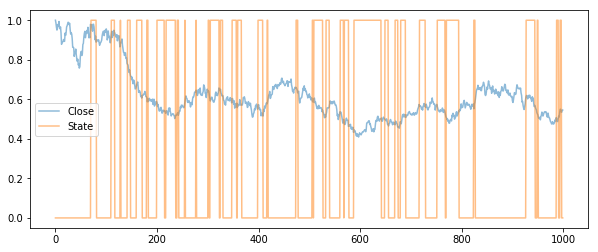

In [5]:
price_df = sim_path()
price_df[['Close', 'State']].plot(figsize=(10, 4), alpha = 0.5);

In [6]:
price_df

,Close,State,Ch,Ch2,Ch3,Ch4
0,1.000000,0,0.000000,0.000000,0.000000e+00,0.000000e+00
1,0.985885,0,-0.014216,0.000202,-2.872754e-06,4.083801e-08
2,0.964182,0,-0.022260,0.000495,-1.102973e-05,2.455197e-07
...,...,...,...,...,...,...
997,0.534556,0,-0.003547,0.000013,-4.462267e-08,1.582732e-10
998,0.543795,0,0.017135,0.000294,5.030738e-06,8.620034e-08
999,0.545879,0,0.003824,0.000015,5.593211e-08,2.139020e-10


## Only Price 

### Train and test sets

The input data for an LSTM cell in pytorch must be of dimension:

* `(seq_len, batch, input_size) = (seq_len, N_samples, 1)`.

In [ ]:
N_samples = 100

paths = [sim_path() for i in range(N_samples)]
inputs = np.array([p.Close.values for p in paths])
targets = np.array([p.State.values for p in paths])

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [ ]:
inputs.size(), targets.size()

In [ ]:
list(inputs.chunk(inputs.size(1), dim=1))[0].size()

### Build the model

In [ ]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.sigmoid(self.linear(h_t2))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


In [ ]:
# build the model
seq = Sequence()
seq.double()

In [ ]:
criterion = nn.CrossEntropyLoss()

# use LBFGS as optimizer since we can load the whole data to train
# optimizer = optim.LBFGS(seq.parameters(), lr=0.8)

optimizer = optim.Adam(seq.parameters())

In [ ]:
out = seq(inputs)
out

In [ ]:
out.view(-1, 2).size()

In [ ]:
targets.view(-1).size()

In [ ]:
out.size(), targets.size()

In [ ]:
criterion(out.view(-1, 2), targets.view(-1))

### Train

In [ ]:
#begin to train
for i in tqdm_notebook(range(20), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs)
        loss = criterion(out.view(-1, 2), targets.view(-1))
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()


In [ ]:
out = seq(inputs)
out

## Price and changes

### Train and test sets

The input data for an LSTM cell in pytorch must be of dimension:

* `(seq_len, batch, input_size) = (seq_len, N_samples, 5)`.

In [ ]:
N_samples = 100

paths = [sim_path() for i in range(N_samples)]
inputs = np.array([p.drop('State', axis=1).values for p in paths])
targets = np.array([p.State.values for p in paths])

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [ ]:
inputs.size(), targets.size()

In [ ]:
list(inputs.chunk(inputs.size(1), dim=1))[0].view(N_samples, -1).size()

### Build the model

In [ ]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(5, 51)
        self.lstm2 = nn.LSTMCell(51, 51)
        self.linear = nn.Linear(51, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t = torch.zeros(input.size(0), 51, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), 51, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.sigmoid(self.linear(h_t2))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


In [ ]:
# build the model
seq = Sequence()
seq.double()

In [ ]:
criterion = nn.CrossEntropyLoss()

# use LBFGS as optimizer since we can load the whole data to train
# optimizer = optim.LBFGS(seq.parameters(), lr=0.1)

optimizer = optim.Adam(seq.parameters())

In [ ]:
out = seq(inputs)
out

In [ ]:
out.size(), targets.size()

In [ ]:
out.view(-1, 2).size()

In [ ]:
targets.view(-1).size()

In [ ]:
criterion(out.view(-1, 2), targets.view(-1))

### Train

In [ ]:
#begin to train
for i in tqdm_notebook(range(20), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs)
        loss = criterion(out.view(-1, 2), targets.view(-1))
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()


In [ ]:
out = seq(inputs)
out

## Support and Resistance

In [7]:
def add_support_resistance(df, fast=30, slow=120):
    return df.assign(Resistance_fast = df.Close.rolling(30).max(),
                     Resistance_slow = df.Close.rolling(120).max(),
                     Support_fast = df.Close.rolling(30).min(),
                     Support_slow = df.Close.rolling(120).min())

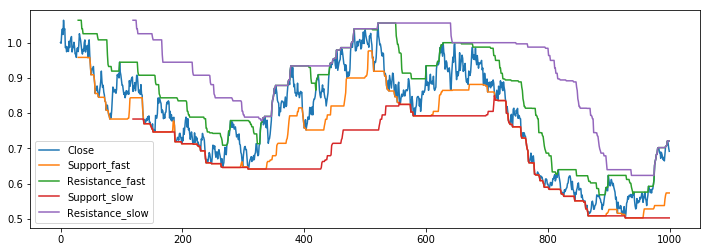

In [8]:
price_df = add_support_resistance(sim_path())

price_df[['Close', 'Support_fast', 'Resistance_fast',
          'Support_slow', 'Resistance_slow']].plot(figsize=(12, 4))

In [9]:
price_df

,Close,State,Ch,Ch2,Ch3,Ch4,Resistance_fast,Resistance_slow,Support_fast,Support_slow
0,1.000000,0,0.000000,0.000000,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
1,0.998048,0,-0.001954,0.000004,-7.463772e-09,1.458628e-11,NaN,NaN,NaN,NaN
2,1.026891,0,0.028490,0.000812,2.312534e-05,6.588464e-07,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
997,0.715658,0,-0.007235,0.000052,-3.787476e-07,2.740311e-09,0.720855,0.720855,0.573239,0.502416
998,0.701933,0,-0.019365,0.000375,-7.261724e-06,1.406219e-07,0.720855,0.720855,0.573239,0.502416
999,0.691425,0,-0.015083,0.000227,-3.431008e-06,5.174824e-08,0.720855,0.720855,0.573239,0.502416


### Train and test sets

The input data for an LSTM cell in pytorch must be of dimension:

* `(seq_len, batch, input_size) = (seq_len, N_samples, 5)`.

In [83]:
N_samples = 100

input_variables = ['Close']
target_variables = ['Resistance_fast', 'Resistance_slow',
                    'Support_fast', 'Support_slow']

paths = [add_support_resistance(sim_path()) for i in range(N_samples)]
inputs = np.array([p[input_variables].values for p in paths])
targets = np.array([p[target_variables].values for p in paths])

In [11]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [12]:
inputs.size(), targets.size()

(torch.Size([100, 1000, 1]), torch.Size([100, 1000, 4]))

In [13]:
list(inputs.chunk(inputs.size(1), dim=1))[0].view(N_samples, -1).size()

torch.Size([100, 1])

### Build the model

In [97]:
class Sequence(nn.Module):
    def __init__(self, h0=1, h1=51, h2=51, hL=1):
        super(Sequence, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.linear = nn.Linear(h2, hL)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

    
class Sequence3(nn.Module):
    def __init__(self, h0=1, h1=10, h2=10, h3=10, hL=1):
        super(Sequence3, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.lstm3 = nn.LSTMCell(h2, h3)
        self.linear = nn.Linear(h3, hL)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        h_t3 = torch.ones(input.size(0), self.h3, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), self.h3, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            output = self.linear(h_t3)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

    
class Sequence4(nn.Module):
    def __init__(self, h0=1, h1=5, h2=5, h3=5, h4=5, hL=1):
        super(Sequence4, self).__init__()
        self.h0 = h0
        self.h1 = h1
        self.h2 = h2
        self.h3 = h3
        self.h4 = h4
        self.hL = hL
        self.lstm1 = nn.LSTMCell(h0, h1)
        self.lstm2 = nn.LSTMCell(h1, h2)
        self.lstm3 = nn.LSTMCell(h2, h3)
        self.lstm4 = nn.LSTMCell(h3, h4)
        self.linear = nn.Linear(h4, hL)

    def forward(self, input):
        outputs = []
        h_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        c_t = torch.zeros(input.size(0), self.h1, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), self.h2, dtype=torch.double)
        h_t3 = torch.ones(input.size(0), self.h3, dtype=torch.double)
        c_t3 = torch.zeros(input.size(0), self.h3, dtype=torch.double)
        h_t4 = torch.ones(input.size(0), self.h4, dtype=torch.double)
        c_t4 = torch.zeros(input.size(0), self.h4, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t.view(N_samples, -1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            h_t3, c_t3 = self.lstm3(h_t2, (h_t3, c_t3))
            h_t4, c_t4 = self.lstm4(h_t3, (h_t4, c_t4))
            output = self.linear(h_t4)
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


In [98]:
# build the model
seq = Sequence4(hL=4)#Sequence(h0=1, h1=20, h2=10, hL=4)
seq.double()

Sequence4(
  (lstm1): LSTMCell(1, 5)
  (lstm2): LSTMCell(5, 5)
  (lstm3): LSTMCell(5, 5)
  (lstm4): LSTMCell(5, 5)
  (linear): Linear(in_features=5, out_features=4, bias=True)
)

In [99]:
mse = nn.MSELoss(reduce=False)
def criterion(y_hat, y_true):
    loss = mse(y_hat[:, 119:, :], y_true[:, 119:, :]).sqrt().\
        div(y_true[:, 119:, :]).mean()
    return loss

In [100]:
out = seq(inputs)
out

tensor([[[-0.0766, -0.0992,  0.4970,  0.1808],
         [-0.0024, -0.1543,  0.4951,  0.1524],
         [ 0.0379, -0.2011,  0.4759,  0.1230],
         ...,
         [ 0.0561, -0.2333,  0.4642,  0.0870],
         [ 0.0561, -0.2333,  0.4642,  0.0870],
         [ 0.0561, -0.2333,  0.4642,  0.0870]],

        [[-0.0766, -0.0992,  0.4970,  0.1808],
         [-0.0024, -0.1543,  0.4951,  0.1524],
         [ 0.0379, -0.2011,  0.4759,  0.1230],
         ...,
         [ 0.0553, -0.2317,  0.4647,  0.0854],
         [ 0.0553, -0.2317,  0.4647,  0.0854],
         [ 0.0553, -0.2317,  0.4647,  0.0854]],

        [[-0.0766, -0.0992,  0.4970,  0.1808],
         [-0.0024, -0.1543,  0.4951,  0.1524],
         [ 0.0379, -0.2011,  0.4759,  0.1230],
         ...,
         [ 0.0561, -0.2333,  0.4642,  0.0871],
         [ 0.0561, -0.2333,  0.4642,  0.0871],
         [ 0.0561, -0.2333,  0.4642,  0.0871]],

        ...,

        [[-0.0766, -0.0992,  0.4970,  0.1808],
         [-0.0024, -0.1543,  0.4951,  0.1524]

In [101]:
out.size(), targets.size()

(torch.Size([100, 1000, 4]), torch.Size([100, 1000, 4]))

In [102]:
criterion(out, targets)

tensor(0.9281, dtype=torch.float64)

### Train

In [104]:
losses = []

In [109]:
optimizer = optim.Adam(seq.parameters(), lr=1e-4)

In [110]:
for i in tqdm_notebook(range(500), desc='Epoch:'):
    
    def closure():
        optimizer.zero_grad()
        out = seq(inputs)
        loss = criterion(out, targets)
        losses.append(loss.detach().numpy())
        loss.backward()
        return loss
    optimizer.step(closure)
    
    if i % 10 == 0:
        print('i:', i, ', loss:', losses[-1])
    # begin to predict, no need to track gradient here
#     with torch.no_grad():
#         future = 1000
#         pred = seq(test_input, future=future)
#         loss = criterion(pred[:, :-future], test_target)
#         print('test loss:', loss.item())
#         y = pred.detach().numpy()


i: 0 , loss: 0.0109527583604541
i: 10 , loss: 0.010806837314353975
i: 20 , loss: 0.010690444000764956
i: 30 , loss: 0.010575258399329567
i: 40 , loss: 0.010463053627695682
i: 50 , loss: 0.010354847327459022
i: 60 , loss: 0.010250704690094342
i: 70 , loss: 0.010150309339886835
i: 80 , loss: 0.010053295563573067
i: 90 , loss: 0.009959258359374177
i: 100 , loss: 0.009867855102137195
i: 110 , loss: 0.00977878736565279
i: 120 , loss: 0.009691816346995803
i: 130 , loss: 0.009606755877297013
i: 140 , loss: 0.009523464278036914
i: 150 , loss: 0.009441839012395026
i: 160 , loss: 0.009361810615173072
i: 170 , loss: 0.009283338161224905
i: 180 , loss: 0.009206405219234182
i: 190 , loss: 0.009131016742622617
i: 200 , loss: 0.009057196393516388
i: 210 , loss: 0.00898498418275651
i: 220 , loss: 0.008914434262474112
i: 230 , loss: 0.008845612694982331
i: 240 , loss: 0.008778595056017554
i: 250 , loss: 0.008713463700205851
i: 260 , loss: 0.008650304559374577
i: 270 , loss: 0.008589203387607096
i: 280 

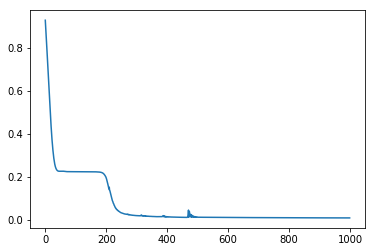

In [111]:
plt.plot(np.array(losses));

In [112]:
with torch.no_grad():
    out = seq(inputs)
out.size()

torch.Size([100, 1000, 4])

Loss: 0.007709141354825658


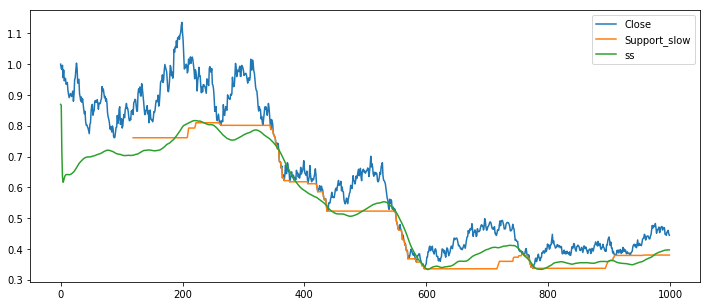

In [123]:
j = np.random.randint(0, N_samples)
y_hat = out.detach().numpy()
y_hat_df = DataFrame(data=y_hat[j,...], columns=['rf', 'rs', 'sf', 'ss'])
res_j = pd.concat((paths[j], y_hat_df), axis=1)
print('Loss:', criterion(out, targets).item())
res_j[['Close', 'Support_slow', 'ss']].plot(figsize=(12, 5));

### Test sample 

In [72]:
test_samples = 10

input_variables = ['Close']
target_variables = ['Resistance_fast', 'Resistance_slow',
                    'Support_fast', 'Support_slow']

test_paths = [add_support_resistance(sim_path()) for i in range(test_samples)]
test_inputs = np.array([p[input_variables].values for p in test_paths])
test_targets = np.array([p[target_variables].values for p in test_paths])

In [73]:
test_inputs = torch.from_numpy(test_inputs)
test_targets = torch.from_numpy(test_targets)

In [74]:
test_inputs.size()

torch.Size([10, 1000, 1])

In [75]:
with torch.no_grad():
    test_out = seq(test_inputs)
test_out.size()

torch.Size([10, 1000, 4])

Loss: 0.0019386608605562398


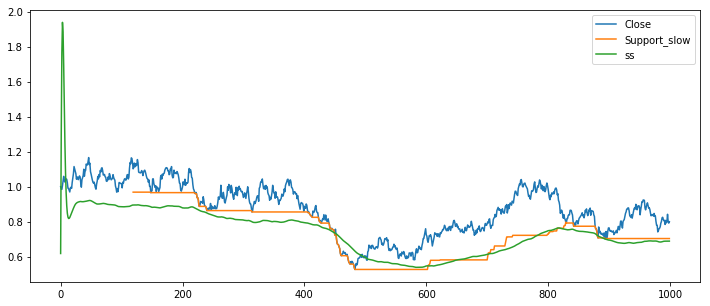

In [96]:
j = np.random.randint(0, test_samples)
y_hat = test_out.detach().numpy()
y_hat_df = DataFrame(data=y_hat[j,...], columns=['rf', 'rs', 'sf', 'ss'])
res_j = pd.concat((test_paths[j], y_hat_df), axis=1)
print('Loss:', criterion(test_out, test_targets).item())
res_j[['Close', 'Support_slow', 'ss']].plot(figsize=(12, 5));